# COCKATIEL IMDB exemple

## Load dataset and model

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizerFast

from cockatiel import CustomRobertaForSequenceClassification, batch_predict, batcher, tokenize

/home/agustin-martin.picard/torch2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-05-27 14:55:17,958 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>


[nltk_data] Downloading package punkt to /home/agustin-
[nltk_data]     martin.picard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/agustin-
[nltk_data]     martin.picard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
raw_dataset = pd.read_csv('./data/IMDB_Dataset_clean.csv')
raw_dataset = np.array(raw_dataset)[:, 1:]
raw_dataset.shape

(49997, 2)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = RobertaTokenizerFast.from_pretrained("wrmurray/roberta-base-finetuned-imdb")
model = CustomRobertaForSequenceClassification.from_pretrained("wrmurray/roberta-base-finetuned-imdb").to(device)
model = model.eval()

In [4]:
ypred, labels = batch_predict(model.forward, tokenizer, raw_dataset[:100], 32, device)

features, labels = batch_predict(model.features, tokenizer, raw_dataset[:100], 32, device)
ypred_bis = model.end_model(features)

print("accuracy for classic model:", torch.mean((torch.argmax(ypred, -1) == labels.to(device)).float()))
print("accuracy for model in 'two parts':", torch.mean((torch.argmax(ypred_bis, -1) == labels.to(device)).float()))

accuracy for classic model: tensor(0.9900, device='cuda:0')
accuracy for model in 'two parts': tensor(0.9900, device='cuda:0')


## Data formatting for COCKATIEL

Predict to split dataset in reviews predicted positives and reviews predicted negatives:

In [5]:
positive_reviews = []
negative_reviews = []

with torch.no_grad():
  for input_batch in batcher(raw_dataset[:20000], batch_size=32): 
    r = np.array(list(map(lambda z: z[0], input_batch)))

    tokenized_batch = tokenize(r, tokenizer, device)
    preds = model(**tokenized_batch)
    positive_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 1)[0]]))
    negative_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 0)[0]]))

raw_dataset_pos = list(map(lambda z: z[0], positive_reviews))
raw_dataset_neg = list(map(lambda z: z[0], negative_reviews))

Create excerpt datasets (in sentences):

In [6]:
sentence_separators = ['.', '...', '?', '!', '..']

def excerpt_fct(raw_dataset):
  excerpt_dataset = []
  for review in raw_dataset[:100000]:
    review = str(review)

    for sep in sentence_separators:
      review = review.replace(sep, '.')
  
    cropped_review = review.split('.')
    for crop in cropped_review:
      if len(crop):
        crop = crop + '.'
        while crop[0] == ' ':
          crop = crop[1:]
      
        if crop[0].isupper():  
          excerpt_dataset.append(crop)
  return excerpt_dataset
  
excerpt_dataset_pos = excerpt_fct(raw_dataset_pos)
excerpt_dataset_neg = excerpt_fct(raw_dataset_neg)

print(len(excerpt_dataset_pos), ' positives excerpts created.')
print(len(excerpt_dataset_neg), ' negatives excerpts created.')

108194  positives excerpts created.
111385  negatives excerpts created.


## Run COCKATIEL 

In [7]:
from cockatiel import COCKATIEL

In [8]:
len_data = 50000  

with torch.no_grad():
  cockatiel_explainer_pos = COCKATIEL(model, tokenizer, components = 20, batch_size = 64, device = device)
  segments_pos, u_segments_pos, factorization_pos, global_importance_pos = cockatiel_explainer_pos.extract_concepts(excerpt_dataset_pos[:len_data],
                                                                                            raw_dataset_pos[:(len_data//10)], 
                                                                                            1, limit_sobol = 1_000)

In [10]:
with torch.no_grad():
  cockatiel_explainer_neg = COCKATIEL(model, tokenizer, 20, 64, device)
  segments_neg, u_segments_neg, factorization_neg, global_importance_neg = cockatiel_explainer_neg.extract_concepts(excerpt_dataset_neg[:len_data], 
                                                                                            raw_dataset_neg[:(len_data//10)], 
                                                                                            0, limit_sobol = 1_000)

## Visualisations

In [ ]:
#If we don't want to run COCKATIEL, we can use this version:
#COCKATIEL was trained with len_data = 50000 for each label

import pickle

segments_pos = pickle.load(open("data/trained_cockatiel/segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open("data/trained_cockatiel/u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open("data/trained_cockatiel/factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open("data/trained_cockatiel/global_importance_pos.pkl",'rb'))

segments_neg = pickle.load(open("data/trained_cockatiel/segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open("data/trained_cockatiel/u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open("data/trained_cockatiel/factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open("data/trained_cockatiel/global_importance_neg.pkl",'rb'))

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from cockatiel import occlusion_concepts, print_legend, viz_concepts

### Visualisation of importances of concepts

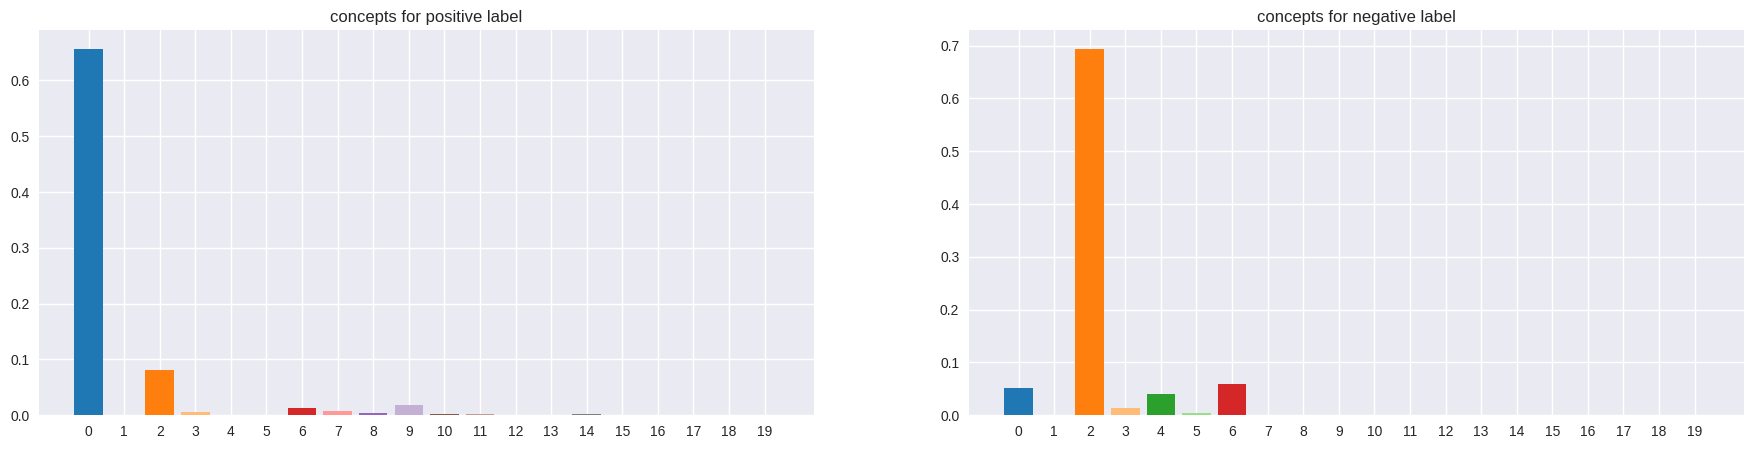

In [12]:
plt.figure(figsize=(22, 5))

plt.subplot(121)
cm = plt.get_cmap('tab20')
plt.bar(range(len(global_importance_pos)), global_importance_pos, color=cm.colors, tick_label=range(len(global_importance_pos)))
plt.title("concepts for positive label")

plt.subplot(122)
cm = plt.get_cmap('tab20')
plt.bar(range(len(global_importance_neg)), global_importance_neg, color=cm.colors, tick_label=range(len(global_importance_neg)))
plt.title("concepts for negative label")

plt.show()

### Visualization of the occlusion part

First, we chose the sentences looked for the visualization of the occlusion part.
We base ourselves on the plot above to choose concepts for the two classes which are quite important.
We take the first n most important sentences for each concept looked at.

In [13]:
n = 10 #number of reviews for each labels and each concept
m_pos = 2 #number of concept looked for the positive class (we look the m_pos more importants)
m_neg = 3 #number of concept looked for the negative class (we look the m_neg more importants)

l_concept_id_pos = np.argsort(global_importance_pos)[::-1][:m_pos]
l_concept_id_neg = np.argsort(global_importance_neg)[::-1][:m_neg]

l_mip_sentences_pos, l_mip_sentences_neg = [], []

#we add sentence of positive label
for concept_id in l_concept_id_pos:
  mip_sentences_ids = np.argsort(u_segments_pos[:, concept_id])[::-1][:n]
  mip_sentences = np.array(segments_pos)[mip_sentences_ids]
  l_mip_sentences_pos.append(mip_sentences)

#we add sentence of negative label
for concept_id in l_concept_id_neg:
  mip_sentences_ids = np.argsort(u_segments_neg[:, concept_id])[::-1][:n]
  mip_sentences = np.array(segments_neg)[mip_sentences_ids]
  l_mip_sentences_neg.append(mip_sentences)


l_mip_sentences_pos = np.array(l_mip_sentences_pos)
l_mip_sentences_pos = l_mip_sentences_pos.flatten()
l_mip_sentences_neg = np.array(l_mip_sentences_neg)
l_mip_sentences_neg = l_mip_sentences_neg.flatten() 

Create dictionnaries for legend with a color for each concept:

In [14]:
#We use m_pos+m_neg concepts, so we have to create a dictionnary "colors" with m_pos+m_neg colors. 
#In the dictionnary "label_to_criterion", we add the corresponding concept for each color.

colors = {
    0: "rgba(9, 221, 55, ", #green
    1: "rgba(9, 221, 161, ", #turquoise
    #2: "rgba(9, 175, 221, ", #blue
    2: "rgba(221, 9, 34, ", #red
    3: "rgba(221, 9, 140,", #pink
    4: "rgba(221, 90, 9, ", #orange
}

label_to_criterion = {
    0: "Positive label: concept1",
    1: "Positive label: concept2",
    #2: "Positive label: concept3",
    2: "Negative label: concept1",
    3: "Negative label: concept2",
    4: "Negative label: concept3",
}


#sanity check:
if len(label_to_criterion.keys()) != len(colors.keys()) or len(label_to_criterion.keys()) != (m_pos + m_neg):
    print("Error: check that you have the correct number of colors and labels in your dictionaries to cover the number of concepts being looked at")

Visualisation of occlusion part:

In [15]:
print_legend(colors, label_to_criterion)

print("positive predicted reviews:")
print("\n")
i = 0
for sentence in l_mip_sentences_pos:
  if i%n == 0 :
    print("\n")
    print(str(n) + " most important reviews for positive predicted label - concept" + str(i//n + 1) +":")
    print("\n")
  phi = occlusion_concepts(sentence, model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
  phi /= np.max(np.abs(phi)) + 1e-5
  viz_concepts(sentence, phi, colors, ignore_words = [])
  i += 1

print("\n")
print("negative predicted reviews:")
print("\n")
i = 0
for sentence in l_mip_sentences_neg:
  if i%n == 0 :
    print("\n")
    print(str(n) + " most important reviews for negative predicted label - concept" + str(i//n + 1) +":")
    print("\n")
  phi = occlusion_concepts(sentence,  model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
  phi /= np.max(np.abs(phi)) + 1e-5
  viz_concepts(sentence, phi, colors, ignore_words = [])
  i +=1

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:


